### Problem Statement :

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.
 
The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
 
The company wants to know:
Which variables are significant in predicting the price of a house, and
How well those variables describe the price of a house.
 
Also, determine the optimal value of lambda for ridge and lasso regression.



### Business Goal 
 
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [106]:
# Importing all required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [107]:
# Importing dataset

df = pd.read_excel('surprise_housing.xlsx')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [108]:
# check for null values in all categorical columns

df.select_dtypes(include='object').isnull().sum()[df.select_dtypes(include='object').isnull().sum()>0]

# Replace NA with None in the following columns below : 

for col in ('Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Electrical'):
    
    df[col]=df[col].fillna('None')

In [109]:
# Drop the following columns that have more than 85% values associated to a specific value

def crr():
    column = []
    categorical_columns = df.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(df[col].value_counts().max() >= 1241):
            column.append(col)
    return column

crrs = crr()

# Remove the columns with skewed data

df.drop(crrs, axis = 1, inplace = True)

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,0,0,0,0,None,0,2,2008,Normal,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,0,0,0,0,None,0,5,2007,Normal,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,0,0,0,0,None,0,9,2008,Normal,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,272,0,0,0,None,0,2,2006,Abnorml,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,0,0,0,0,None,0,12,2008,Normal,250000


In [110]:
# check the null values in the numerical data

df.select_dtypes(include=['int64','float']).isnull().sum()[df.select_dtypes(include=['int64','float']).isnull()
                                                                  .sum()>0]

df['LotFrontage'] = df['LotFrontage'].replace(np.nan, df['LotFrontage'].median())
df['MasVnrArea'] = df['MasVnrArea'].replace(np.nan, df['MasVnrArea'].median())
df['GarageYrBlt']=df['GarageYrBlt'].fillna(0).astype(int)

In [111]:
# Create a new column named IsRemodelled - This column would determine whether the house has been remodelled or not based on 
# the difference between remodelled and built years

def remodel(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
df['IsRemodelled'] = df.apply(remodel, axis=1)
df.head()    

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,IsRemodelled
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,0,0,0,None,0,2,2008,Normal,208500,0
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,0,0,0,None,0,5,2007,Normal,181500,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,0,0,0,None,0,9,2008,Normal,223500,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,0,0,0,None,0,2,2006,Abnorml,140000,1
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,0,0,0,None,0,12,2008,Normal,250000,0


In [112]:
# Create a new column named BuiltOrRemodelledAge and determine the age of the building at the time of selling

def bora(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
       
df['BuiltOrRemodelAge'] = df.apply(bora, axis=1)
df.head()  

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,IsRemodelled,BuiltOrRemodelAge
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,0,0,None,0,2,2008,Normal,208500,0,5
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,0,0,None,0,5,2007,Normal,181500,0,31
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,0,0,None,0,9,2008,Normal,223500,1,6
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,0,0,None,0,2,2006,Abnorml,140000,1,36
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,0,0,None,0,12,2008,Normal,250000,0,8


In [113]:
# Garage Yr Built less than 2000 will be considered as old (0) else new(1). 

def getGarageConstructionPeriod(row):
    if row == 0:
        return 0
    elif row >= 1900 and row < 2000:        
        return 0
    else:   
        return 1
    
df['OldOrNewGarage'] = df['GarageYrBlt'].apply(getGarageConstructionPeriod)
df.head() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,0,None,0,2,2008,Normal,208500,0,5,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,0,None,0,5,2007,Normal,181500,0,31,0
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,0,None,0,9,2008,Normal,223500,1,6,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,0,None,0,2,2006,Abnorml,140000,1,36,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,0,None,0,12,2008,Normal,250000,0,8,1


In [114]:
df.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace = True)

In [115]:
# Drop the following columns that have more than 50% values associated to a specific value

def ghnvc():
    column = []
    numerical_columns = df.select_dtypes(include=['int64', 'float'])
    for col in (numerical_columns):
        if(df[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = ghnvc()
df.drop(columnsToBeRemoved, axis = 1, inplace = True)

df.drop(['MoSold'], axis = 1, inplace = True)

In [116]:
# Check if there are any duplicate values in the dataset

df[df.duplicated(keep=False)]

# Checking outliers at 25%,50%,75%,90%,95% and above

df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,BuiltOrRemodelAge,OldOrNewGarage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,103.117123,443.639726,567.240411,1057.429452,...,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,180921.195890,0.476712,22.950000,0.275342
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,180.731373,456.098091,441.866955,438.705324,...,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,79442.502883,0.499629,20.640653,0.446840
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,-1.000000,0.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,223.000000,795.750000,...,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,129975.000000,0.000000,4.000000,0.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,477.500000,991.500000,...,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,163000.000000,0.000000,14.000000,0.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,808.000000,1298.250000,...,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,214000.000000,1.000000,41.000000,1.000000
90%,1314.100000,120.000000,92.000000,14381.700000,8.000000,7.000000,335.000000,1065.500000,1232.000000,1602.200000,...,9.000000,1.000000,3.000000,757.100000,262.000000,130.000000,278000.000000,1.000000,56.000000,1.000000
95%,1387.050000,160.000000,104.000000,17401.150000,8.000000,8.000000,456.000000,1274.000000,1468.000000,1753.000000,...,10.000000,2.000000,3.000000,850.100000,335.000000,175.050000,326100.000000,1.000000,58.000000,1.000000
99%,1445.410000,190.000000,137.410000,37567.640000,10.000000,9.000000,791.280000,1572.410000,1797.050000,2155.050000,...,11.000000,2.000000,3.000000,1002.790000,505.460000,285.820000,442567.010000,1.000000,60.000000,1.000000


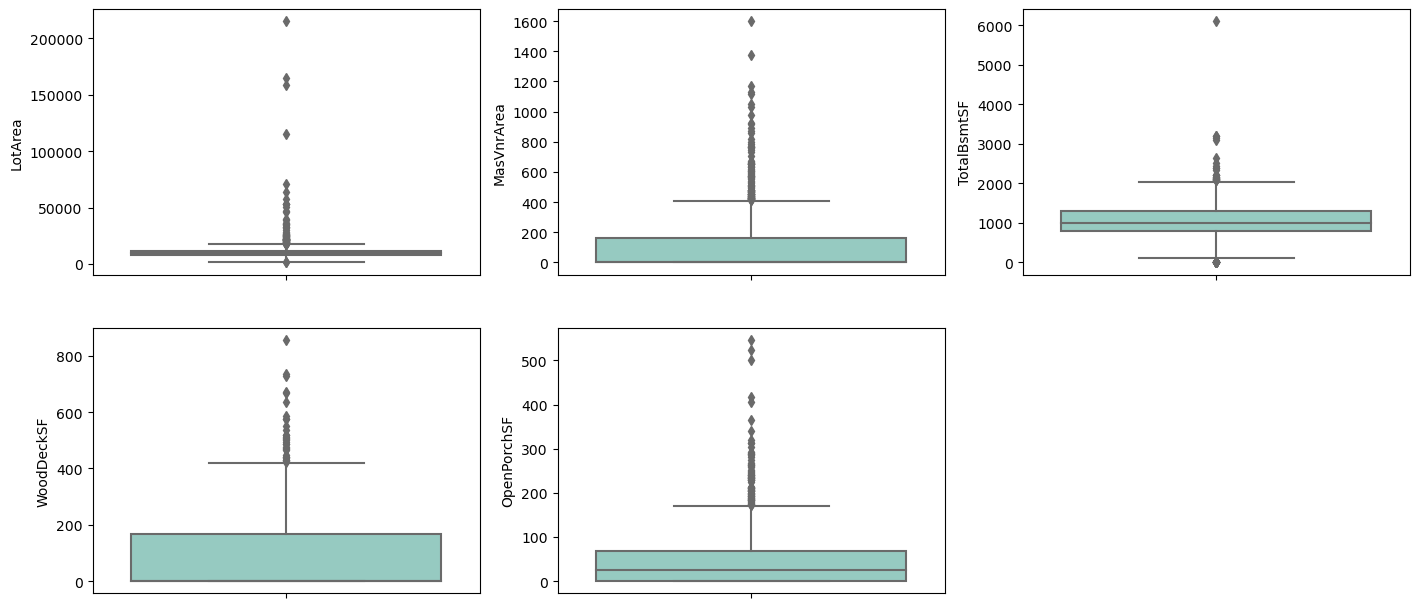

In [ ]:
# Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', data = df)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', data = df)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', data = df)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', data = df)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', data = df)
plt.show()

In [118]:
# Removing Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = df['LotArea'].quantile(0.98)
df = df[df["LotArea"] < nn_quartile_LotArea]

# Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = df['MasVnrArea'].quantile(0.98)
df = df[df["MasVnrArea"] < nn_quartile_MasVnrArea]

# Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = df['TotalBsmtSF'].quantile(0.99)
df = df[df["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

# Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = df['WoodDeckSF'].quantile(0.99)
housingInfo = df[df["WoodDeckSF"] < nn_quartile_WoodDeckSF]

# Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = df['OpenPorchSF'].quantile(0.99)
housingInfo = df[df["OpenPorchSF"] < nn_quartile_OpenPorchSF]

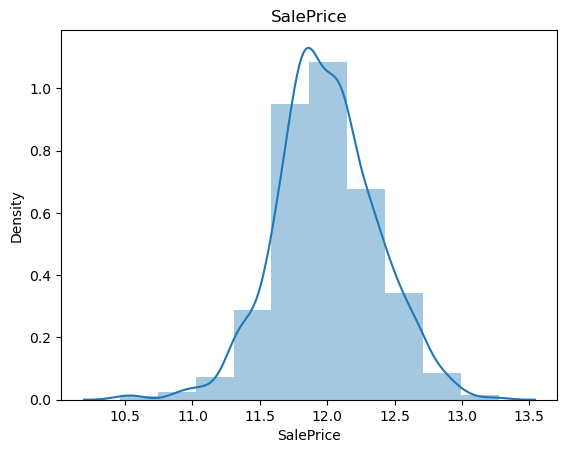

In [119]:
df['SalePrice'] = np.log1p(df['SalePrice'])

plt.title('SalePrice')
sns.distplot(df['SalePrice'], bins=10)
plt.show()

<Figure size 1000x500 with 0 Axes>

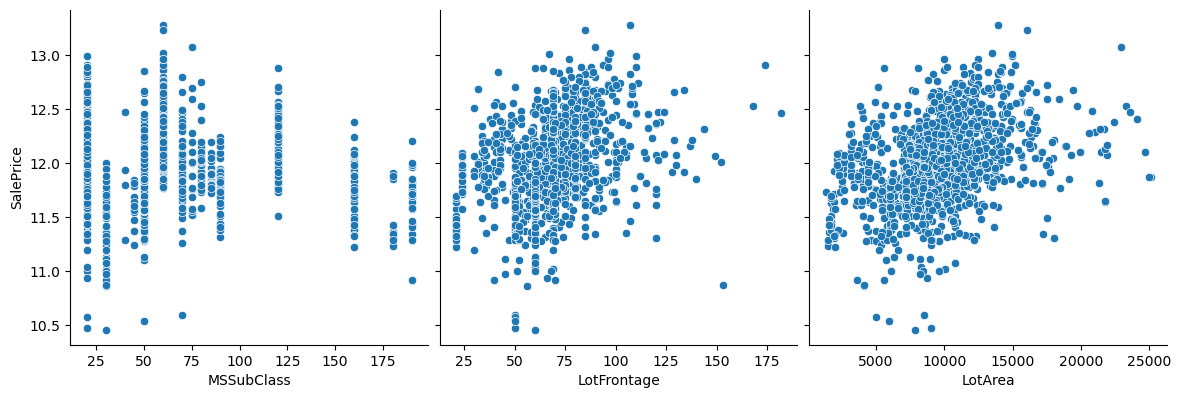

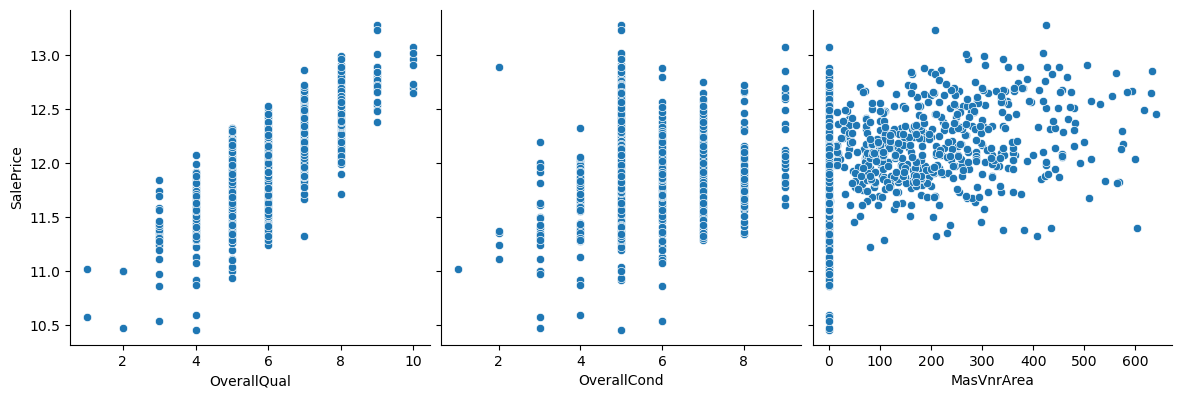

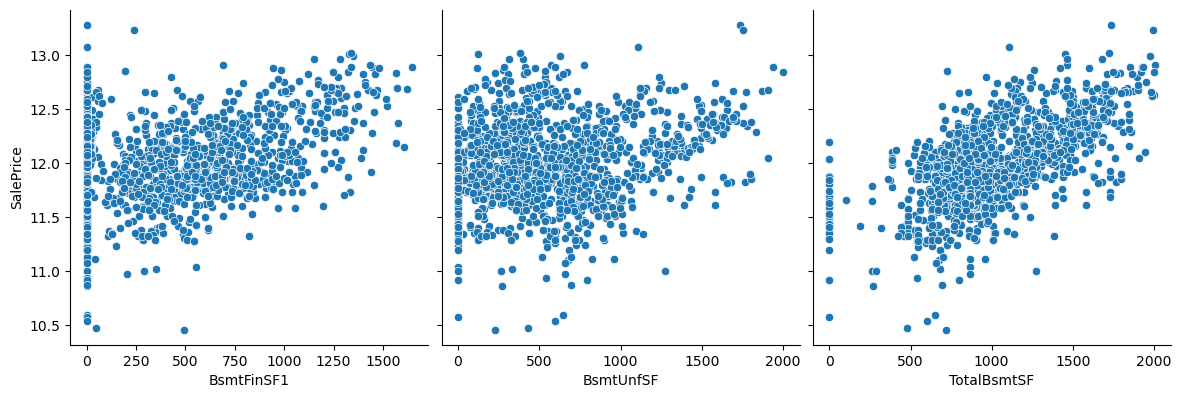

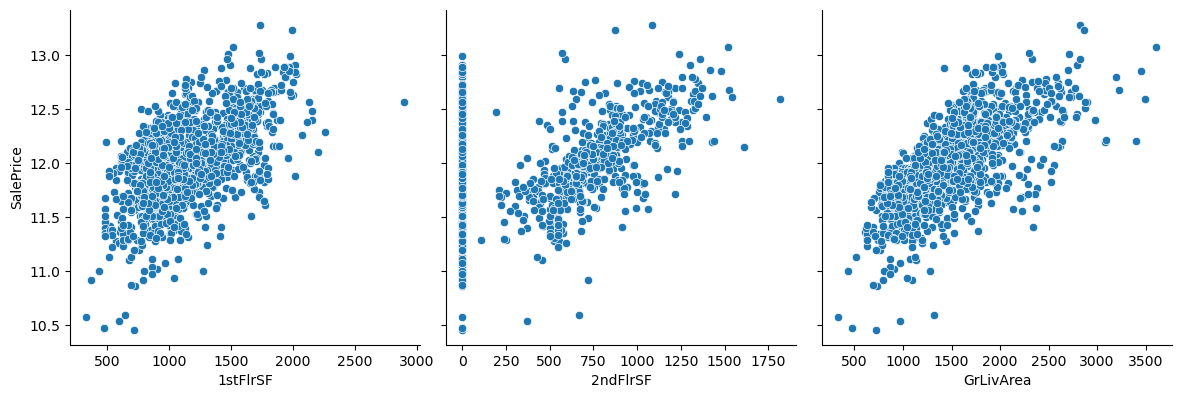

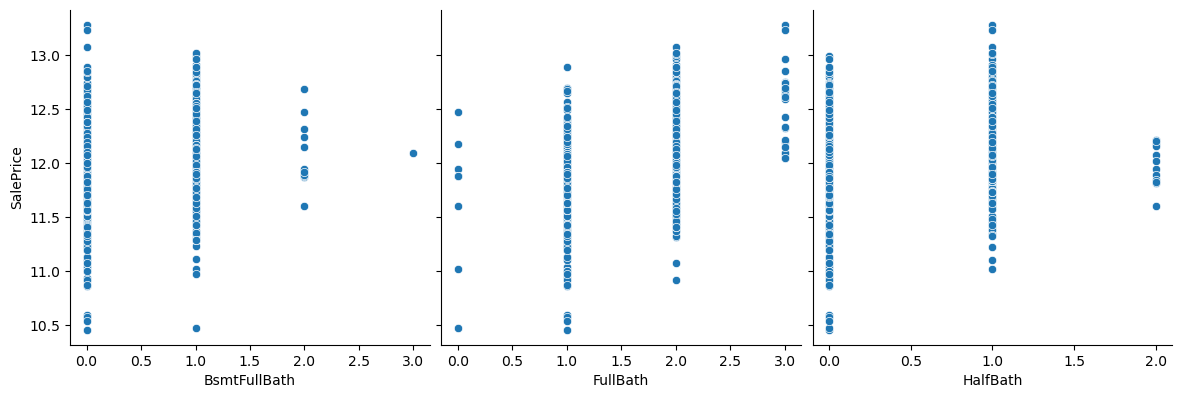

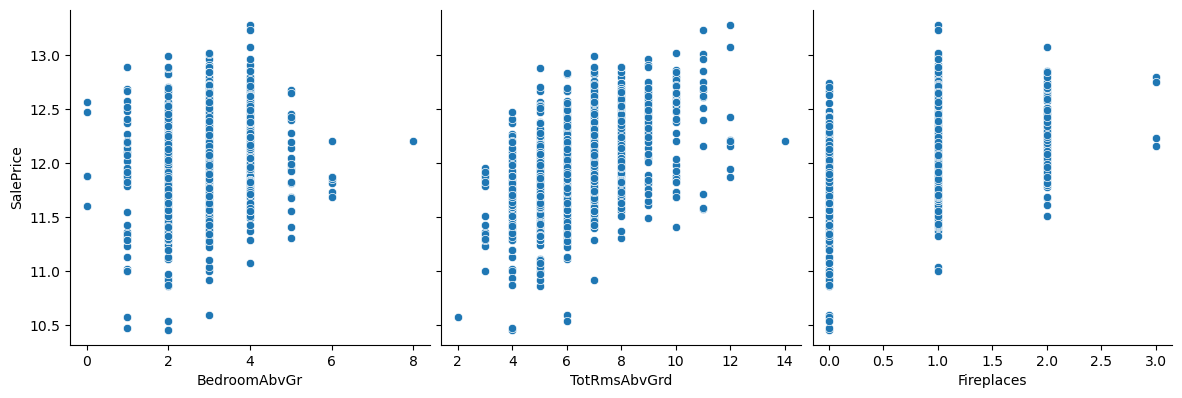

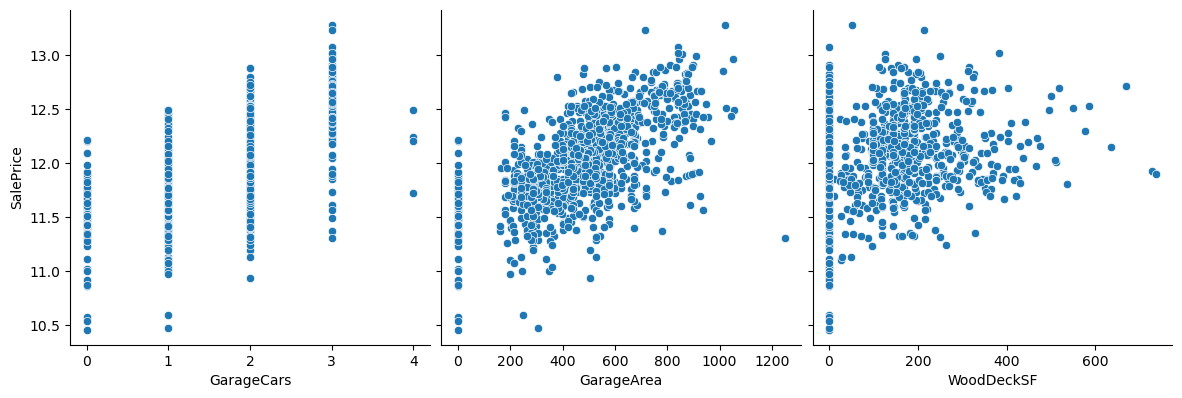

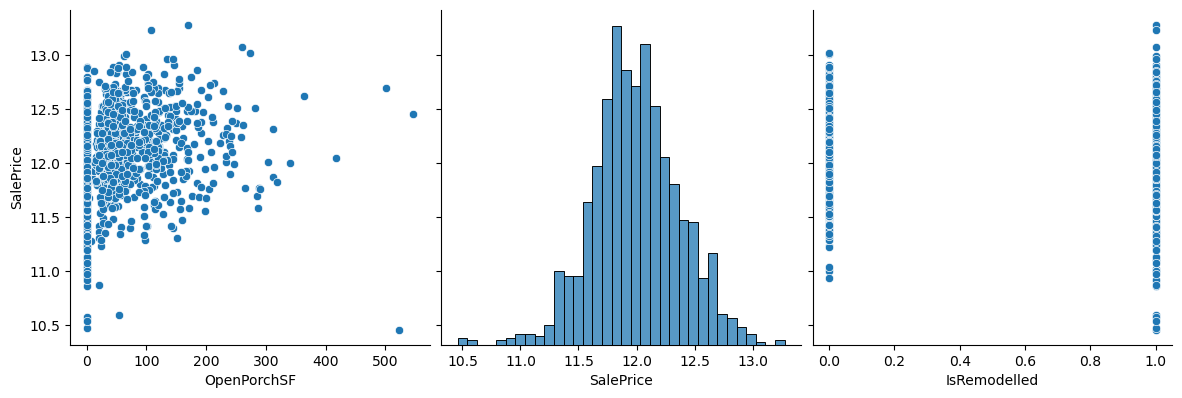

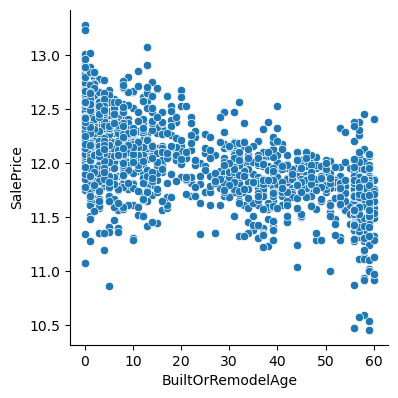

In [120]:
# Check the numerical values using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(df, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['OpenPorchSF','SalePrice', 'IsRemodelled'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['BuiltOrRemodelAge'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

In [122]:
# Removing the highly correlated variables
df.corr()
df.drop(['TotRmsAbvGrd', 'GarageArea'], axis = 1, inplace = True)
df.shape

(1386, 47)

In [123]:
# Converting categorical to numerical

df['d_LotShape'] = df['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
df['d_ExterQual'] = df['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
df['d_BsmtQual'] = df['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
df['d_BsmtExposure'] = df['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
df['d_BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
df['d_HeatingQC'] = df['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
df['d_KitchenQual'] = df['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
df['d_FireplaceQu'] = df['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
df['d_GarageFinish'] = df['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })
df['d_BldgType'] = df['BldgType'].map({'Twnhs': 5, 'TwnhsE': 4, 'Duplex': 3, '2fmCon': 2, '1Fam': 1, 'None': 0 })
df['d_HouseStyle'] = df['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
df['d_Fence'] = df['Fence'].map({'GdPrv': 4, 'GdWo': 3, 'MnPrv': 2, 'MnWw': 1, 'None': 0 })
df['d_LotConfig'] = df['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 'None': 0  })
df['d_MasVnrType'] = df['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
df['d_SaleCondition'] = df['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 'Alloca': 0, 'AdjLand': 0, 'None': 0})


df = df.drop(['Id', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'BldgType', 'HouseStyle', 'Fence', 
                                'LotConfig', 'MasVnrType', 'SaleCondition'], axis=1)

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,d_HeatingQC,d_KitchenQual,d_FireplaceQu,d_GarageFinish,d_BldgType,d_HouseStyle,d_Fence,d_LotConfig,d_MasVnrType,d_SaleCondition
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,5,4,0,2,1,4,0,5,1,1
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,...,5,3,3,2,1,1,0,2,0,1
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,5,4,3,2,1,4,0,5,1,1
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,...,4,4,4,1,1,4,0,4,0,0
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,...,5,4,3,2,1,4,0,2,1,1


In [125]:
# For the following columns create dummies


d_MSZoning = pd.get_dummies(df['MSZoning'], prefix='MSZoning', drop_first = True)
df = pd.concat([df, d_MSZoning], axis = 1)


d_Neighborhood = pd.get_dummies(df['Neighborhood'], prefix='Neighborhood', drop_first = True)
df = pd.concat([df, d_Neighborhood], axis = 1)


d_RoofStyle = pd.get_dummies(df['RoofStyle'], prefix='RoofStyle', drop_first = True)
df = pd.concat([df, d_RoofStyle], axis = 1)


d_Exterior1st = pd.get_dummies(df['Exterior1st'], prefix='Exterior1st', drop_first = True)
df = pd.concat([df, d_Exterior1st], axis = 1)


d_Exterior2nd = pd.get_dummies(df['Exterior2nd'], prefix='Exterior2nd', drop_first = True)
df = pd.concat([df, d_Exterior2nd], axis = 1)


d_Foundation = pd.get_dummies(df['Foundation'], prefix='Foundation', drop_first = True)
df = pd.concat([df, d_Foundation], axis = 1)


d_GarageType = pd.get_dummies(housingInfo['GarageType'], prefix='GarageType', drop_first = True)
df = pd.concat([df, d_GarageType], axis = 1)

df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,...,True,False,False,False,True,False,False,False,False,False
1,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,...,False,False,False,False,True,False,False,False,False,False
2,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,...,True,False,False,False,True,False,False,False,False,False
3,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,...,False,False,False,False,False,False,False,False,True,False
4,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,...,True,False,False,False,True,False,False,False,False,False


In [126]:
# drop the below columns as we now have new columns derived from these columns

df = df.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                                'GarageType'], axis=1)

df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
0,60,65.0,8450,7,5,196.0,706,150,856,856,...,True,False,False,False,True,False,False,False,False,False
1,20,80.0,9600,6,8,0.0,978,284,1262,1262,...,False,False,False,False,True,False,False,False,False,False
2,60,68.0,11250,7,5,162.0,486,434,920,920,...,True,False,False,False,True,False,False,False,False,False
3,70,60.0,9550,7,5,0.0,216,540,756,961,...,False,False,False,False,False,False,False,False,True,False
4,60,84.0,14260,8,5,350.0,655,490,1145,1145,...,True,False,False,False,True,False,False,False,False,False


## Modelling

In [127]:
# Putting all feature variable to X

X = df.drop(['SalePrice'], axis=1).fillna(0)
y = df['SalePrice']

In [128]:
# scaling the features

from sklearn.preprocessing import scale

# storing column names in cols
# scaling (the dataframe is converted to a numpy array)

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageType_None'],
      dtype='object', length=111)

In [129]:
# split into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

## Step 5: Recursive feature elimination (RFE)¶

    Since there are around 111 features, we will use RFE to get the best 50 features out of the 111 features and use the new
    features for further analysis

In [131]:
# Running RFE

lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm)            
rfe = rfe.fit(X_train, y_train)

In [132]:
# RFE assigned to cols

col = X_train.columns[rfe.support_]

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df

,Variable,rfe_support,rfe_ranking
0,MSSubClass,True,1
1,LotArea,True,1
2,OverallQual,True,1
3,OverallCond,True,1
4,BsmtUnfSF,True,1
5,TotalBsmtSF,True,1
6,1stFlrSF,True,1
7,2ndFlrSF,True,1
8,GrLivArea,True,1
9,FullBath,True,1


In [133]:
X_train_rfe = X_train[col]
X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

## Ridge

In [135]:
# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [136]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
21,10.0,-0.077925,-0.083526,1
20,9.0,-0.077875,-0.083539,2
19,8.0,-0.077827,-0.083551,3
22,20,-0.078352,-0.083552,4
18,7.0,-0.077777,-0.083565,5
17,6.0,-0.077724,-0.083580,6
16,5.0,-0.077666,-0.083603,7
15,4.0,-0.077604,-0.083629,8
14,3.0,-0.077550,-0.083689,9
23,50,-0.079172,-0.083754,10


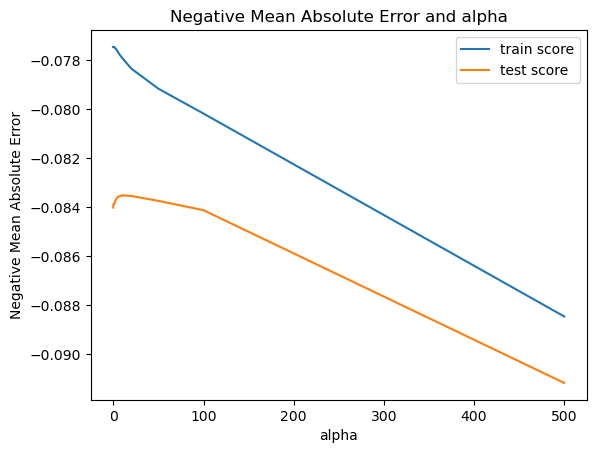

In [137]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [138]:
# get the best estimator for lambda

ridge_model_cv.best_estimator_

Ridge(alpha=10.0)

In [139]:
# check the coefficient values with lambda = 10

alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-1.29780417e-02,  2.61836996e-02,  8.43334388e-02,  3.90365690e-02,
       -2.94233006e-02,  6.16046848e-02,  4.32433462e-02,  3.31541494e-02,
        6.81041997e-02,  1.45363284e-02,  1.72633526e-02,  3.51982501e-02,
       -1.31465745e-02, -2.59569130e-02,  1.83869642e-02,  1.47658600e-02,
        1.68387285e-02,  1.69340603e-02,  1.73477311e-02,  1.03360937e-02,
       -1.21174915e-02,  9.12595735e-03,  1.75997558e-02,  5.49967618e-02,
        2.59527545e-02,  9.36622791e-02,  6.68110497e-02,  1.38541935e-02,
        2.45215085e-02, -1.04188908e-02,  1.92657285e-02, -8.09503462e-03,
        1.18846862e-02,  1.55318813e-02, -9.20963302e-03,  2.12749065e-31,
       -2.12996738e-02,  1.18533872e-02, -1.69748853e-03, -1.22911276e-02,
       -8.32372354e-03, -1.71688158e-02, -2.16423788e-02, -1.69748853e-03,
        1.78383219e-02,  1.24303687e-02,  1.56245266e-02,  1.07990662e-02,
        2.30502804e-02,  4.85605834e-02,  1.34948940e-02,  2.96957444e-02,
        1.42277095e-02, -

In [140]:
# Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

0.014081949190221295

In [141]:
# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

,Features,Coefficient
0,MSSubClass,-0.0130
1,LotArea,0.0262
2,OverallQual,0.0843
3,OverallCond,0.0390
4,BsmtUnfSF,-0.0294
5,TotalBsmtSF,0.0616
6,1stFlrSF,0.0432
7,2ndFlrSF,0.0332
8,GrLivArea,0.0681
9,FullBath,0.0145


In [142]:
# Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict

{'MSSubClass': -0.013,
 'LotArea': 0.0262,
 'OverallQual': 0.0843,
 'OverallCond': 0.039,
 'BsmtUnfSF': -0.0294,
 'TotalBsmtSF': 0.0616,
 '1stFlrSF': 0.0432,
 '2ndFlrSF': 0.0332,
 'GrLivArea': 0.0681,
 'FullBath': 0.0145,
 'HalfBath': 0.0173,
 'GarageCars': 0.0352,
 'IsRemodelled': -0.0131,
 'BuiltOrRemodelAge': -0.026,
 'd_BsmtQual': 0.0184,
 'd_BsmtExposure': 0.0148,
 'd_BsmtFinType1': 0.0168,
 'd_HeatingQC': 0.0169,
 'd_FireplaceQu': 0.0173,
 'd_GarageFinish': 0.0103,
 'd_BldgType': -0.0121,
 'd_HouseStyle': 0.0091,
 'd_SaleCondition': 0.0176,
 'MSZoning_FV': 0.055,
 'MSZoning_RH': 0.026,
 'MSZoning_RL': 0.0937,
 'MSZoning_RM': 0.0668,
 'Neighborhood_BrkSide': 0.0139,
 'Neighborhood_Crawfor': 0.0245,
 'Neighborhood_NWAmes': -0.0104,
 'Neighborhood_NridgHt': 0.0193,
 'Neighborhood_OldTown': -0.0081,
 'Neighborhood_Somerst': 0.0119,
 'Neighborhood_StoneBr': 0.0155,
 'RoofStyle_Shed': -0.0092,
 'Exterior1st_AsphShn': 0.0,
 'Exterior1st_BrkComm': -0.0213,
 'Exterior1st_BrkFace': 0.0119,

#### RFE

In [144]:
# Do an RFE to minimise the features to 15
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm)            
rfe = rfe.fit(X_train_ridge, y_train)

In [145]:
# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

temp1_df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp1_df = temp1_df.loc[temp1_df['rfe_support'] == True]
temp1_df.reset_index(drop=True, inplace=True)

temp1_df['Coefficient'] = temp1_df['Features'].apply(find)
temp1_df = temp1_df.sort_values(by=['Coefficient'], ascending=False)
temp1_df = temp1_df.head(10)
temp1_df

,Features,rfe_support,rfe_ranking,Coefficient
14,MSZoning_RL,True,1,0.0937
1,OverallQual,True,1,0.0843
5,GrLivArea,True,1,0.0681
15,MSZoning_RM,True,1,0.0668
4,TotalBsmtSF,True,1,0.0616
12,MSZoning_FV,True,1,0.0550
23,Foundation_PConc,True,1,0.0486
2,OverallCond,True,1,0.0390
6,GarageCars,True,1,0.0352
24,GarageType_Attchd,True,1,0.0297


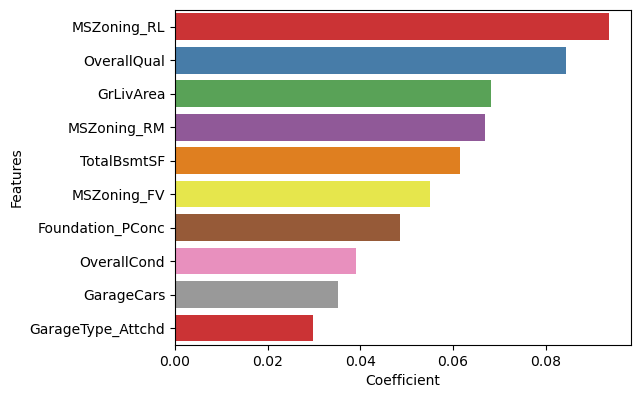

In [146]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp1_df)
plt.show()

Top 10 variables features based on the Ridge Regression model that are significant in predicting the price 
of a house.    

## Lasso

In [147]:
lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [148]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
1,0.0002,-0.077655,-0.083989,1
0,0.0001,-0.077537,-0.083996,2
2,0.0003,-0.077799,-0.084012,3
3,0.0004,-0.077938,-0.084061,4
4,0.0005,-0.078082,-0.084090,5
5,0.001,-0.078767,-0.084378,6
6,0.002,-0.080342,-0.085077,7
7,0.003,-0.081162,-0.085589,8
8,0.004,-0.081834,-0.086076,9
9,0.005,-0.082514,-0.086439,10


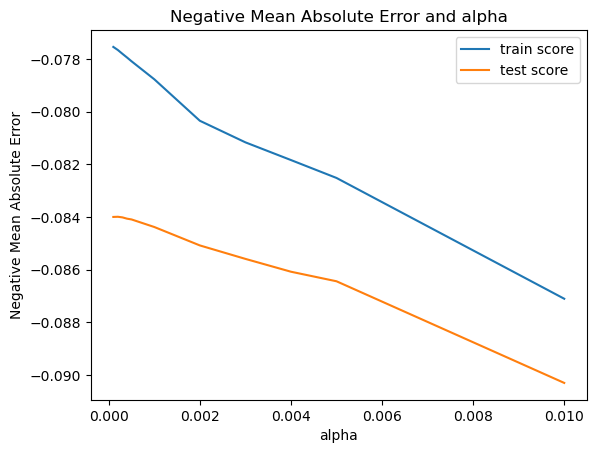

In [149]:
# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [150]:
# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0002)

In [151]:
# check the coefficient values with lambda = 0.0004

alpha = 0.0004

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([-0.011502  ,  0.02622149,  0.08681893,  0.03820449, -0.02988283,
        0.06229886,  0.01581091,  0.00148333,  0.10489107,  0.01225134,
        0.01574182,  0.03669442, -0.01238314, -0.02595855,  0.01734389,
        0.01504836,  0.0159894 ,  0.01647961,  0.01709715,  0.01059241,
       -0.01268059,  0.00725047,  0.01692335,  0.07088136,  0.03293095,
        0.12257542,  0.09129969,  0.01308282,  0.02375313, -0.00971259,
        0.01822426, -0.00830197,  0.00972133,  0.01453574, -0.00841272,
        0.        , -0.02120611,  0.01224171, -0.00288893, -0.0010614 ,
       -0.        , -0.00743182, -0.01854451, -0.00022482,  0.00720702,
        0.00420855,  0.00598024,  0.00719358,  0.02293749,  0.0488585 ,
        0.01274626,  0.02733199,  0.01274295, -0.00828458,  0.01682618])

In [152]:
# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

0.013878316091026188

In [153]:
# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,MSSubClass,-0.0115
1,LotArea,0.0262
2,OverallQual,0.0868
3,OverallCond,0.0382
4,BsmtUnfSF,-0.0299
5,TotalBsmtSF,0.0623
6,1stFlrSF,0.0158
7,2ndFlrSF,0.0015
8,GrLivArea,0.1049
9,FullBath,0.0123


In [154]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'MSSubClass': -0.011501999078981936,
 'LotArea': 0.026221487452242346,
 'OverallQual': 0.08681892732145859,
 'OverallCond': 0.038204494031244346,
 'BsmtUnfSF': -0.02988282530584361,
 'TotalBsmtSF': 0.06229885615989867,
 '1stFlrSF': 0.015810914480285397,
 '2ndFlrSF': 0.0014833316676104086,
 'GrLivArea': 0.10489107239262341,
 'FullBath': 0.01225133658112849,
 'HalfBath': 0.015741823130105713,
 'GarageCars': 0.03669442490356868,
 'IsRemodelled': -0.012383135006849967,
 'BuiltOrRemodelAge': -0.025958546372155118,
 'd_BsmtQual': 0.017343894618151213,
 'd_BsmtExposure': 0.015048363948532104,
 'd_BsmtFinType1': 0.015989398780118565,
 'd_HeatingQC': 0.01647960834392787,
 'd_FireplaceQu': 0.017097151059893824,
 'd_GarageFinish': 0.01059240853199276,
 'd_BldgType': -0.012680591754490484,
 'd_HouseStyle': 0.007250473163814486,
 'd_SaleCondition': 0.01692335019825038,
 'MSZoning_FV': 0.0708813567551654,
 'MSZoning_RH': 0.03293094983556996,
 'MSZoning_RL': 0.12257541598847477,
 'MSZoning_RM': 0.09

## RFE

In [156]:
# Do an RFE to minimise the features 

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm)            
rfe = rfe.fit(X_train_lasso, y_train)

In [157]:
# To get the coefficient values

def find(x):
    return lasso_coeff_dict[x]


temp2_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp2_df = temp2_df.loc[temp2_df['rfe_support'] == True]
temp2_df.reset_index(drop=True, inplace=True)

temp2_df['Coefficient'] = temp2_df['Features'].apply(find)
temp2_df = temp2_df.sort_values(by=['Coefficient'], ascending=False)
temp2_df = temp2_df.head(10)
temp2_df

,Features,rfe_support,rfe_ranking,Coefficient
15,MSZoning_RL,True,1,0.122575
7,GrLivArea,True,1,0.104891
16,MSZoning_RM,True,1,0.091300
1,OverallQual,True,1,0.086819
13,MSZoning_FV,True,1,0.070881
4,TotalBsmtSF,True,1,0.062299
22,Foundation_PConc,True,1,0.048858
2,OverallCond,True,1,0.038204
8,GarageCars,True,1,0.036694
14,MSZoning_RH,True,1,0.032931


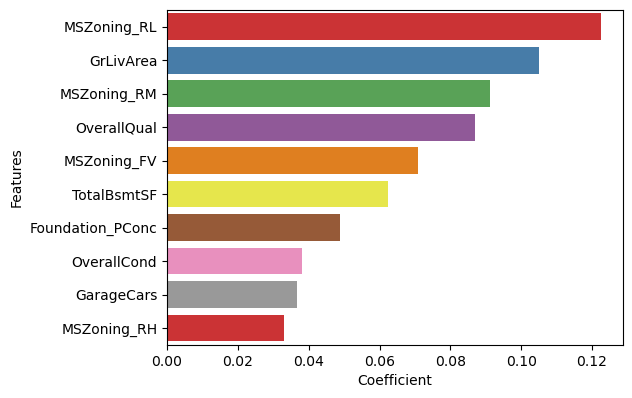

In [158]:
plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp2_df)
plt.show()

Top 10 variables features based on the Lasso Regression model that are significant in predicting the price 
of a house.    

## Final Insight :

- Lasso is better than Ridge

- Optimal lambda value :
    - Ridge - 10
    - Lasso - 0.0004
    
- Mean Squared error :
    - Ridge - 0.0140819
    - Lasso - 0.0138783